In [2]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [3]:
def benchmark(X, Y):
    return -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)


In [4]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [6]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-4.5, 4.5, 5)
Y = np.random.uniform(-4.5, 4.5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [7]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [8]:
df

,x,y,z
0,-0.746802,-3.668953,-1695.133401
1,1.982920,-2.823658,-2231.461373
2,-4.498971,-1.389953,-522.757847
3,-1.779007,-0.929093,-64.660164
4,-3.179197,0.349351,-70.191649


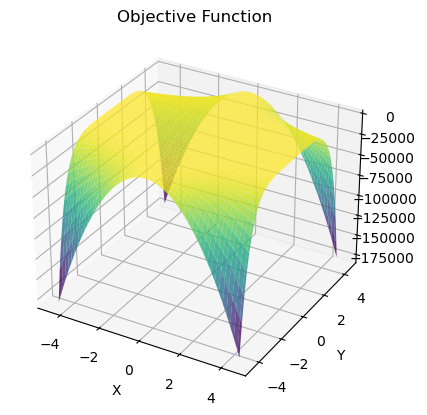

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [10]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [11]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  0.5, "Z": benchmark( 3,  0.5)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,3,0.5,-0.0


In [12]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-4.5, 4.5, 100)
    y_range = np.linspace(-4.5, 4.5, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 15
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the Dataset of Simulation Responses
    scaler_x = StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler_x.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    x_grid_2 = sim_df[['x','y']].to_numpy()
    new_mean, new_std = mc_dropout_predictions(best_model, x_grid_2)

    temp_df = sim_df[['x','y']]
    temp_df['pred_mean'] = new_mean
    temp_df['uncerrtainty'] = new_std

    from skopt.space import Space
    from scipy.spatial.distance import cdist

    space = Space([(-4.5, 4.5), (-4.5, 4.5)])

    beta = 0.7  # Controls exploration vs. exploitation
    d_min = 1

    def acquisition_function(x):
        #UCB Acquisition Function
        x1, x2 = x
        point = temp_df[(temp_df["x"] == x1) & (temp_df["y"] == x2)]
        if len(point) > 0:
            return - (point["pred_mean"].values[0] + beta * point["uncertainty"].values[0])
        else:
            return 0  # Default value if point not in dataset
        
    res = gp_minimize(acquisition_function, space.dimensions, n_calls=50, n_random_starts=7, acq_func="EI", kappa=beta)

    # Extract candidate points
    candidate_points = np.array(res.x_iters)

    # Initialize list of selected points
    selected_points = [candidate_points[0]]  # Start with the best point

    # Ensure distance constraint is met
    for point in candidate_points[1:]:
        distances = cdist([point], selected_points)  # Compute distances to all selected points
        if np.all(distances > d_min):  # Ensure all distances exceed d_min
            selected_points.append(point)
        if len(selected_points) == 5:  # Stop when 5 points are selected
            break

    # Convert selected points into a DataFrame
    physical_test_points = pd.DataFrame(selected_points, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(5, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 4.32360766 -2.98273191]


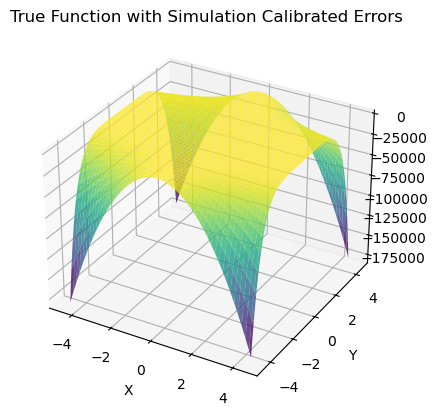

Best hyperparameters:
num_layers: 8
num_units: 200
learning_rate: 0.0009289705275488771
dropout_rate: 0.4130547132130371
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 83705608.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 83704736.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 83704072.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 83702080.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 83702728.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 83699936.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 83699040.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 83696936.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 83693848.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 83686280.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 83681832.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8

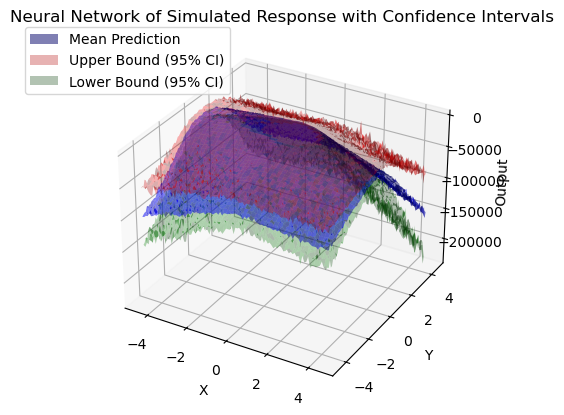

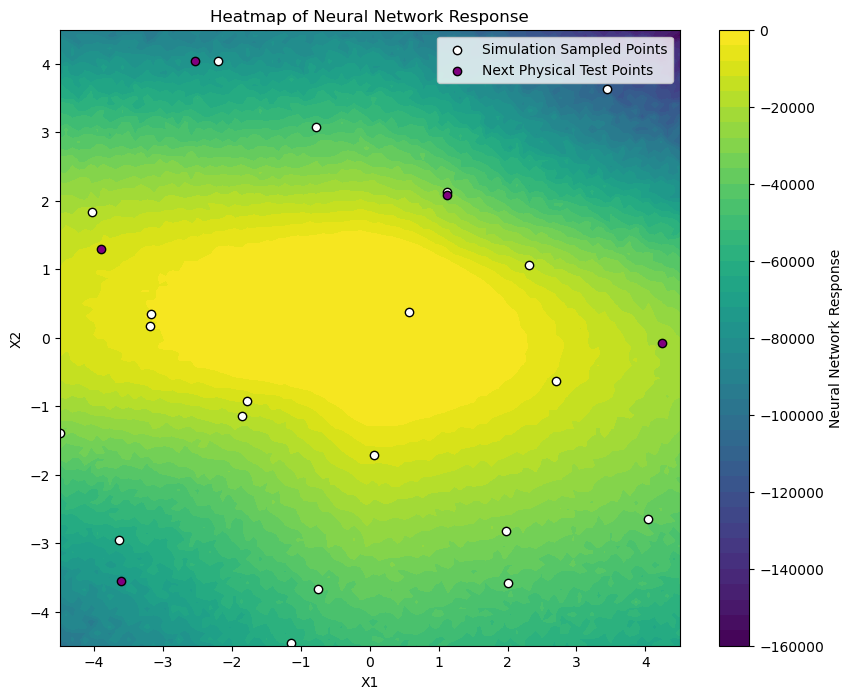

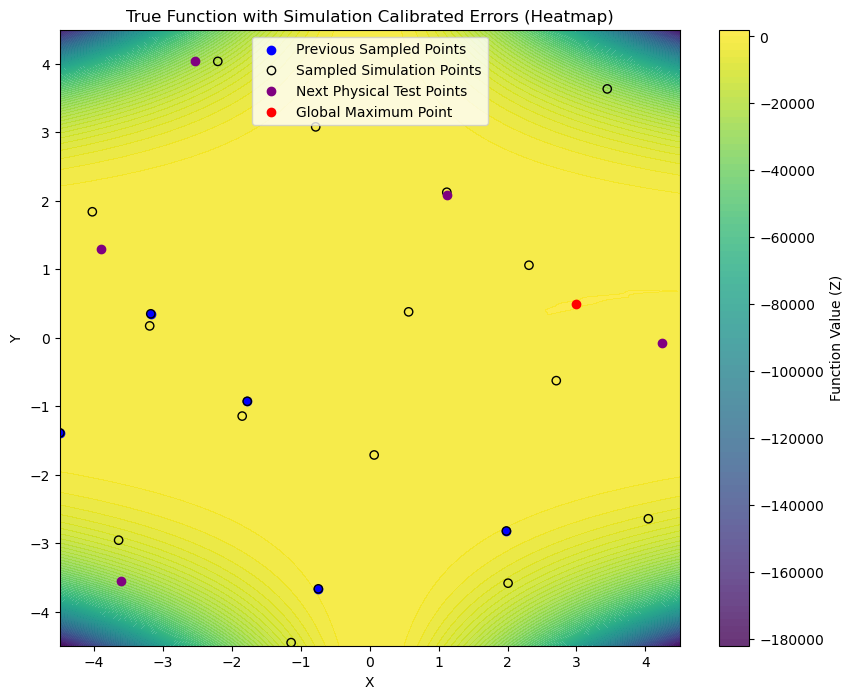

          x         y             z         a         b         sim_z  \
0 -0.746802 -3.668953  -1695.133401  4.323608 -2.982732  -1694.266005   
1  1.982920 -2.823658  -2231.461373  4.323608 -2.982732  -2231.474423   
2 -4.498971 -1.389953   -522.757847  4.323608 -2.982732   -521.819231   
3 -1.779007 -0.929093    -64.660164  4.323608 -2.982732    -64.195661   
4 -3.179197  0.349351    -70.191649  4.323608 -2.982732    -69.863205   
5 -3.905757  1.299393     -4.465844  4.323608 -2.982732     -4.714277   
6 -2.531052  4.038704 -27478.711319  4.323608 -2.982732 -27478.960749   
7 -3.608108 -3.553340 -30158.979641  4.323608 -2.982732 -30158.719512   
8  4.237997 -0.082976    -16.004448  4.323608 -2.982732    -15.846898   
9  1.126967  2.079091   -178.492275  4.323608 -2.982732   -178.350248   

       diff  
0 -0.867396  
1  0.013050  
2 -0.938616  
3 -0.464503  
4 -0.328445  
5  0.248434  
6  0.249430  
7 -0.260129  
8 -0.157551  
9 -0.142027  


In [13]:
df = perform_iteration(df)
print(df)


[ 4.10053966 -3.01583586]


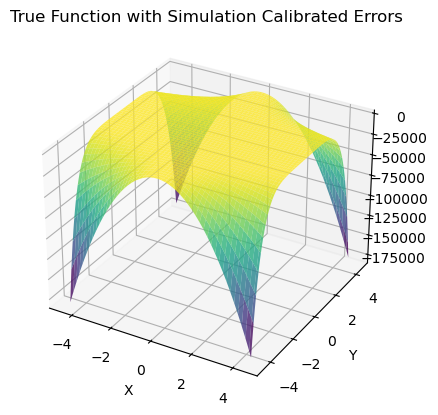

Best hyperparameters:
num_layers: 5
num_units: 168
learning_rate: 0.045744464885250136
dropout_rate: 0.2167264952794274
batch_size: 65
epochs: 184
Epoch 1/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 120237376.0000
Epoch 2/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 116948544.0000
Epoch 3/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 80695256.0000
Epoch 4/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 292456480.0000
Epoch 5/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 78966024.0000
Epoch 6/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 109540456.0000
Epoch 7/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 118040056.0000
Epoch 8/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 119858904.0000
Epoch 9/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 120159440.0000
Epoch 10/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 120217208.0000
Epoch 11/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 120224080.0000
Epoch 12/184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step -

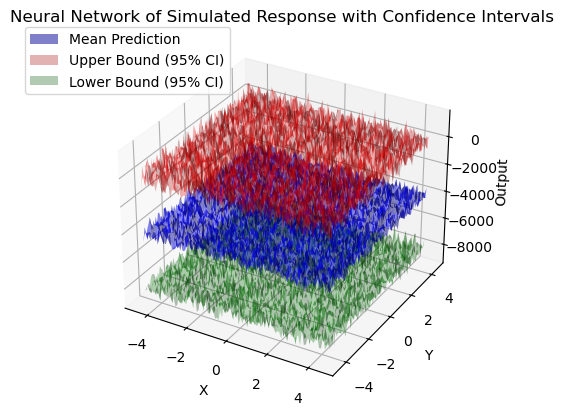

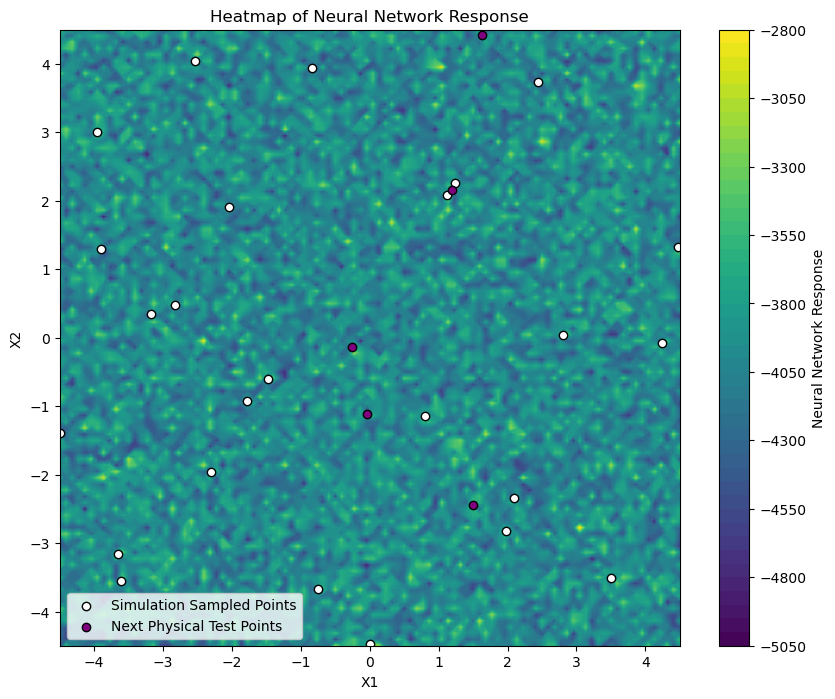

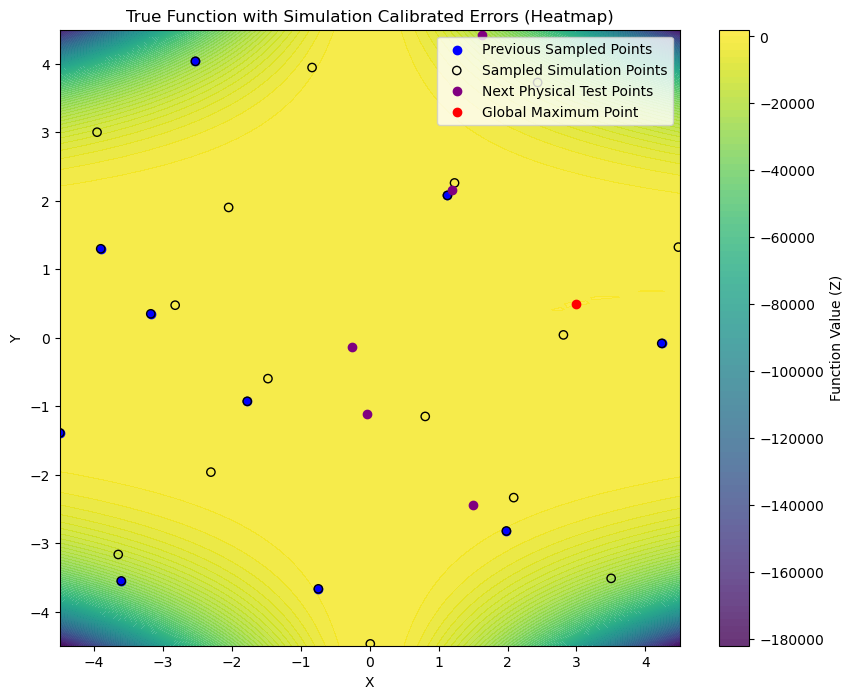

In [14]:
df = perform_iteration(df)

[ 4.0507862  -3.07116678]


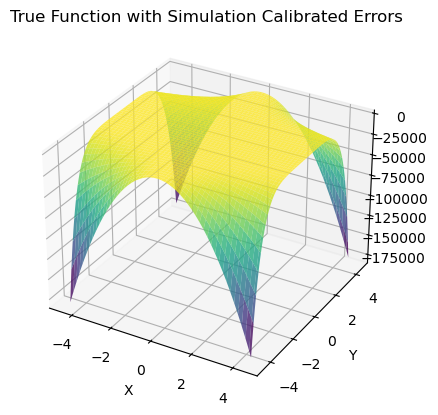

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0016367906441641248
dropout_rate: 0.0
batch_size: 150
epochs: 119
Epoch 1/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 133917672.0000
Epoch 2/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 133916744.0000
Epoch 3/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 133914200.0000
Epoch 4/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 133907816.0000
Epoch 5/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 133893248.0000
Epoch 6/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 133861488.0000
Epoch 7/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 133794424.0000
Epoch 8/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 133656544.0000
Epoch 9/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 133380240.0000
Epoch 10/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 132839032.0000
Epoch 11/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 131812424.0000
Epoch 12/119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 129

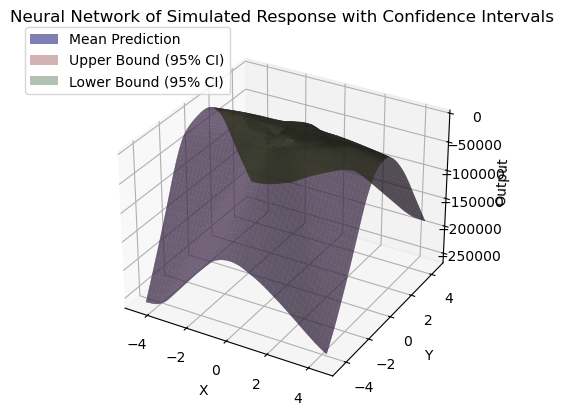

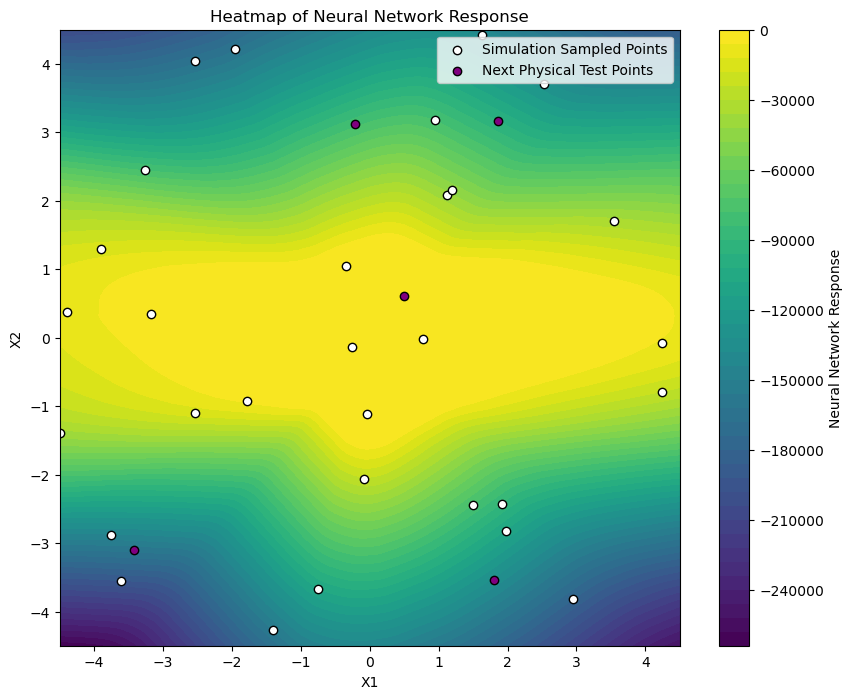

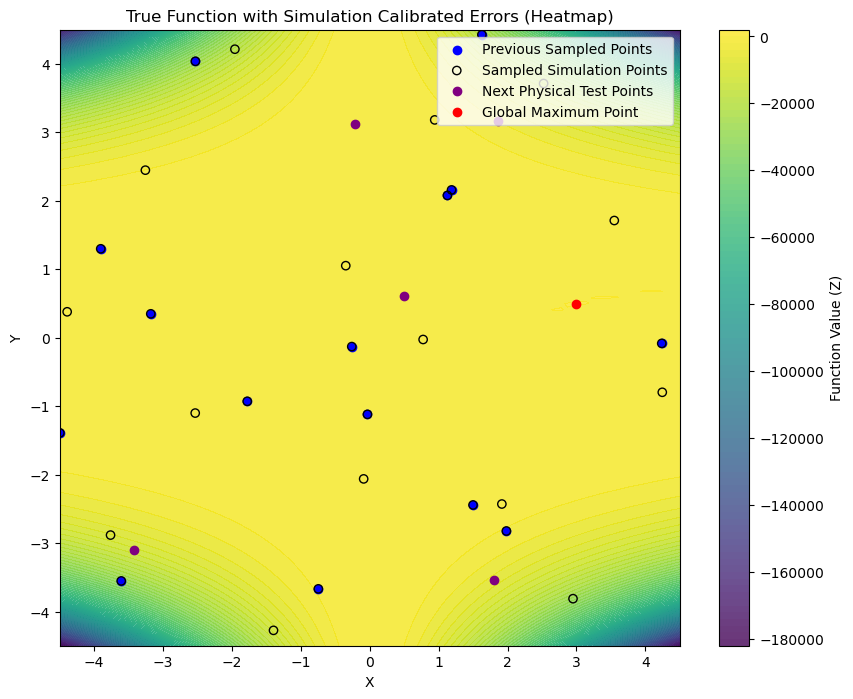

           x         y             z         a         b         sim_z  \
0  -0.746802 -3.668953  -1695.133401  4.050786 -3.071167  -1689.219044   
1   1.982920 -2.823658  -2231.461373  4.050786 -3.071167  -2228.846246   
2  -4.498971 -1.389953   -522.757847  4.050786 -3.071167   -520.429757   
3  -1.779007 -0.929093    -64.660164  4.050786 -3.071167    -63.605652   
4  -3.179197  0.349351    -70.191649  4.050786 -3.071167    -69.334380   
5  -3.905757  1.299393     -4.465844  4.050786 -3.071167     -2.762620   
6  -2.531052  4.038704 -27478.711319  4.050786 -3.071167 -27471.361844   
7  -3.608108 -3.553340 -30158.979641  4.050786 -3.071167 -30152.307627   
8   4.237997 -0.082976    -16.004448  4.050786 -3.071167    -17.227101   
9   1.126967  2.079091   -178.492275  4.050786 -3.071167   -176.927407   
10 -0.261572 -0.129136    -17.899784  4.050786 -3.071167    -17.755649   
11  1.627238  4.428242 -21357.306677  4.050786 -3.071167 -21349.432725   
12  1.186503  2.159678   -231.131056  

In [15]:
df = perform_iteration(df)
print(df)

[ 4.1121251  -3.08910459]


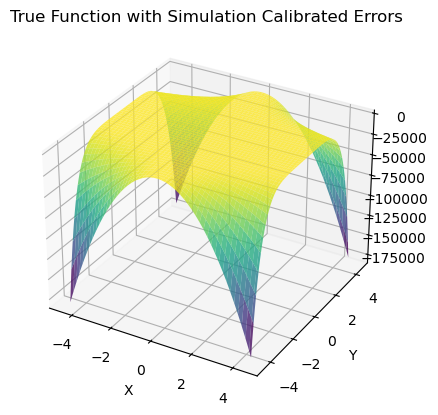

Best hyperparameters:
num_layers: 7
num_units: 199
learning_rate: 0.0021252073916553185
dropout_rate: 0.20718429411318445
batch_size: 82
epochs: 144
Epoch 1/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 111931064.0000
Epoch 2/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 111928376.0000
Epoch 3/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 111923288.0000
Epoch 4/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 111914520.0000
Epoch 5/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 111894328.0000
Epoch 6/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 111850792.0000
Epoch 7/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 111781536.0000
Epoch 8/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 111633864.0000
Epoch 9/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 111344200.0000
Epoch 10/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 110949824.0000
Epoch 11/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 110109784.0000
Epoch 12/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

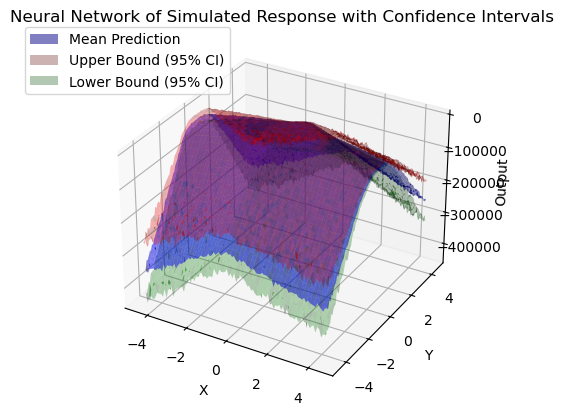

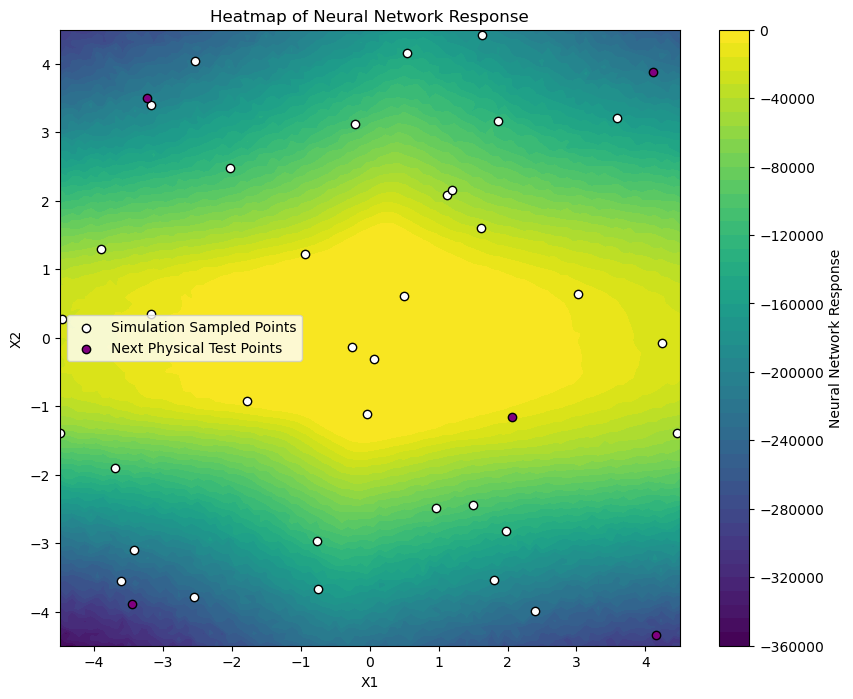

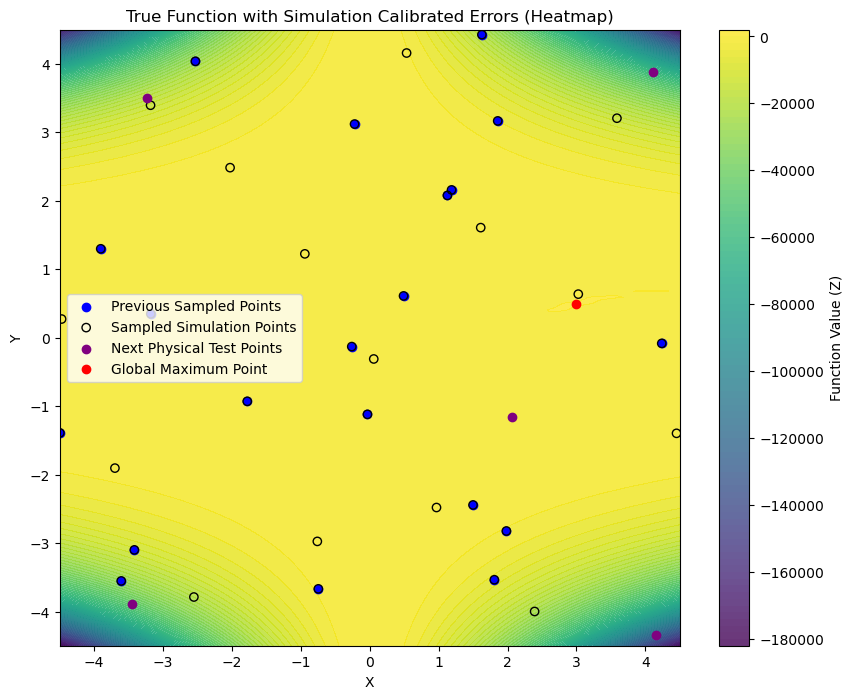

           x         y              z         a         b          sim_z  \
0  -0.746802 -3.668953   -1695.133401  4.112125 -3.089105   -1695.092237   
1   1.982920 -2.823658   -2231.461373  4.112125 -3.089105   -2231.426232   
2  -4.498971 -1.389953    -522.757847  4.112125 -3.089105    -522.908570   
3  -1.779007 -0.929093     -64.660164  4.112125 -3.089105     -64.630276   
4  -3.179197  0.349351     -70.191649  4.112125 -3.089105     -70.571296   
5  -3.905757  1.299393      -4.465844  4.112125 -3.089105      -4.919937   
6  -2.531052  4.038704  -27478.711319  4.112125 -3.089105  -27479.081373   
7  -3.608108 -3.553340  -30158.979641  4.112125 -3.089105  -30158.896880   
8   4.237997 -0.082976     -16.004448  4.112125 -3.089105     -15.661071   
9   1.126967  2.079091    -178.492275  4.112125 -3.089105    -178.309305   
10 -0.261572 -0.129136     -17.899784  4.112125 -3.089105     -17.865052   
11  1.627238  4.428242  -21357.306677  4.112125 -3.089105  -21356.977408   
12  1.186503

In [16]:
df = perform_iteration(df)
print(df)

[ 4.1955674  -3.07736304]


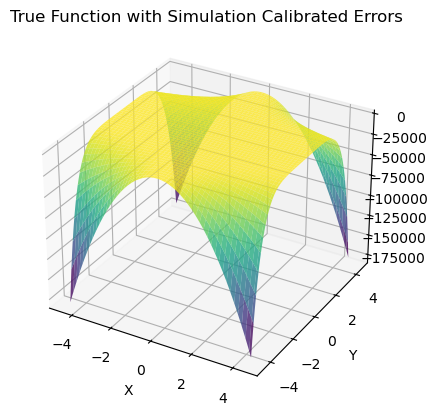

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.001907125354085296
dropout_rate: 0.0
batch_size: 20
epochs: 163
Epoch 1/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 497742560.0000
Epoch 2/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 800980480.0000  
Epoch 3/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 767981568.0000 
Epoch 4/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 819815872.0000  
Epoch 5/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 759058496.0000 
Epoch 6/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 800408192.0000  
Epoch 7/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 572972544.0000 
Epoch 8/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 779209664.0000 
Epoch 9/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 578394816.0000 
Epoch 10/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 520600928.0000 
Epoch 11/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 525291808.0000 
Epoch 12/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 519

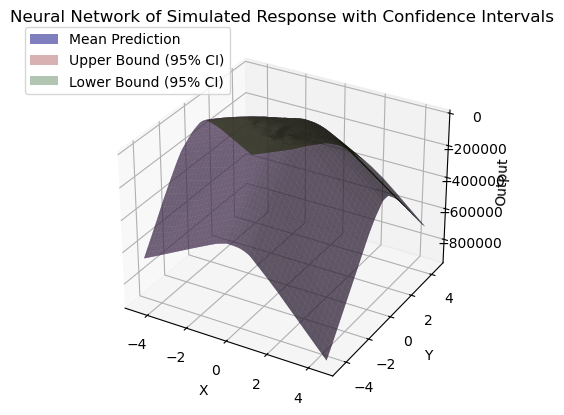

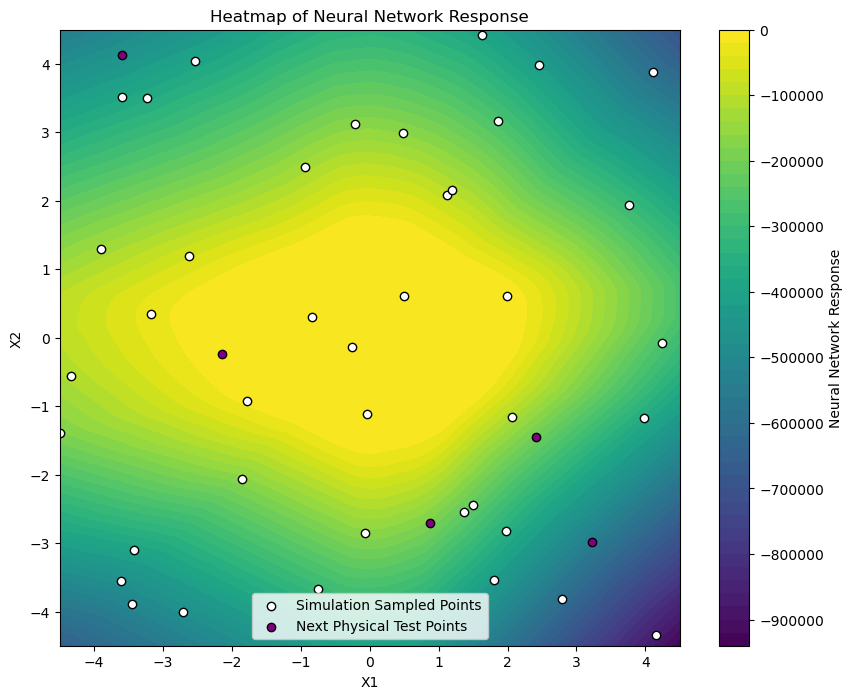

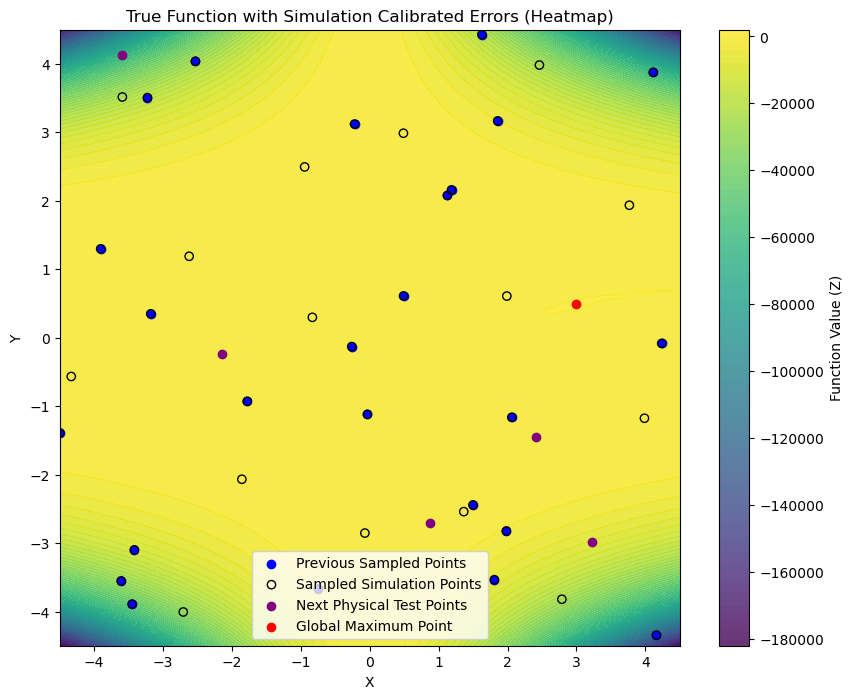

           x         y              z         a         b          sim_z  \
0  -0.746802 -3.668953   -1695.133401  4.195567 -3.077363   -1692.138309   
1   1.982920 -2.823658   -2231.461373  4.195567 -3.077363   -2230.712042   
2  -4.498971 -1.389953    -522.757847  4.195567 -3.077363    -520.626606   
3  -1.779007 -0.929093     -64.660164  4.195567 -3.077363     -63.714847   
4  -3.179197  0.349351     -70.191649  4.195567 -3.077363     -69.206335   
5  -3.905757  1.299393      -4.465844  4.195567 -3.077363      -2.938065   
6  -2.531052  4.038704  -27478.711319  4.195567 -3.077363  -27474.808465   
7  -3.608108 -3.553340  -30158.979641  4.195567 -3.077363  -30154.890688   
8   4.237997 -0.082976     -16.004448  4.195567 -3.077363     -17.472113   
9   1.126967  2.079091    -178.492275  4.195567 -3.077363    -177.949052   
10 -0.261572 -0.129136     -17.899784  4.195567 -3.077363     -17.761215   
11  1.627238  4.428242  -21357.306677  4.195567 -3.077363  -21353.823787   
12  1.186503

In [17]:
df = perform_iteration(df)
print(df)